<a href="https://colab.research.google.com/github/vijaygwu/robotics/blob/main/DEO_Learning_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning a Dielectric Elastomer Oscillator (DEO) Model from Data

This notebook is **self-contained**:
- Generates **synthetic DEO-like time-series data** (voltage input → strain output) from a nonlinear, history-dependent dynamical model
- Trains two learned models:
  1) A **windowed MLP** (feed-forward)  
  2) An **LSTM** (sequence model)
- Compares against a simple **physics-inspired baseline** (first-order linear model)
- Evaluates generalization on held-out waveforms

> Notes: The synthetic simulator is *not* a full multiphysics DEA model; it is designed to capture the right *qualitative* features: nonlinear electromechanical drive, viscoelastic lag (hysteresis), and oscillatory behavior.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(7)

# If you have PyTorch installed (common on most class setups), we will use it.
# If not, you can switch the ML sections to scikit-learn models.
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 1) Synthetic DEO-like simulator

We model a soft actuator driven by an electric field:
- Input: voltage \(V(t)\)
- Output: strain/displacement \(x(t)\)

Key ingredients:
- **Nonlinear electrostatic drive**: \(p(t) \propto V(t)^2\) (field energy scales with square)
- **Mechanical dynamics**: a second-order mass–spring–damper with mild nonlinearity
- **Viscoelastic memory**: an internal state \(z(t)\) (Maxwell element) that lags behind \(x(t)\)
- **Observed output** includes a small contribution from the internal viscoelastic state

This produces:
- Hysteresis-like lag
- Frequency-dependent response
- Nonlinear behavior under changing amplitude


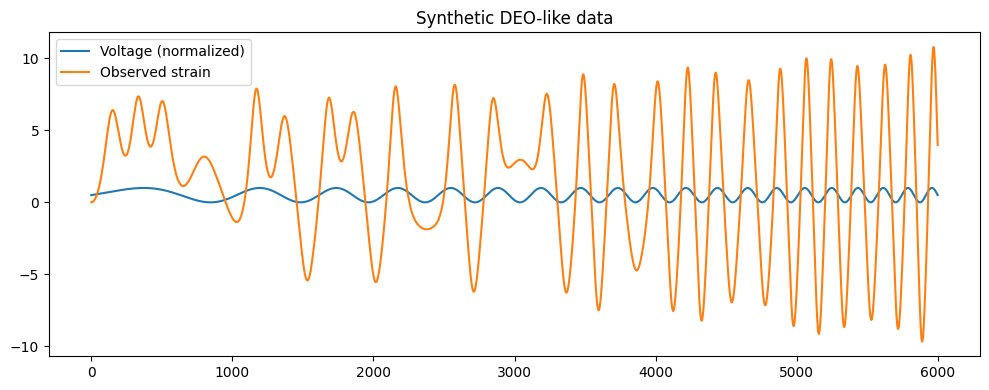

In [ ]:
def simulate_deo(
    V,
    dt=1e-3,
    # "Physics-ish" parameters (tuned for qualitative behavior)
    alpha=3.5e-4,   # electrostatic drive scaling
    k=8.0,          # stiffness
    c=0.25,         # damping
    m=1.0,          # effective mass
    k3=25.0,        # cubic stiffness (nonlinearity)
    tau=0.05,       # viscoelastic time constant (seconds)
    gamma=0.35,     # how much viscoelastic state contributes to observed output
    leak=0.02,      # slow drift/leak of viscoelastic state
    noise_std=0.002 # observation noise
):
    '''
    Simulate a simplified DEO-like system.
    Inputs:
      V: array shape [T] of voltage
      dt: timestep
    Returns:
      x_obs: observed strain/displacement, shape [T]
      x_true: true mechanical state
      z: internal viscoelastic state
    '''
    T = len(V)
    x = 0.0
    v = 0.0
    z = 0.0

    x_true = np.zeros(T, dtype=np.float64)
    z_hist = np.zeros(T, dtype=np.float64)
    x_obs = np.zeros(T, dtype=np.float64)

    for t in range(T):
        # Nonlinear "Maxwell pressure" proxy: p ~ V^2
        p = alpha * (V[t] ** 2)

        # Viscoelastic internal state lags behind x
        # dz/dt = (x - z)/tau - leak*z
        dz = (x - z) / tau - leak * z

        # Mechanical dynamics (soft structure)
        # m x'' + c x' + k x + k3 x^3 = p - (small coupling to viscoelastic lag)
        # Add coupling term so memory influences force slightly
        coupling = 1.5 * (z - x)
        a = (p - c * v - k * x - k3 * (x ** 3) + coupling) / m

        # Euler integration
        v = v + dt * a
        x = x + dt * v
        z = z + dt * dz

        x_true[t] = x
        z_hist[t] = z

        # Observed output includes viscoelastic contribution + measurement noise
        x_obs[t] = x + gamma * z + np.random.normal(0.0, noise_std)

    return x_obs, x_true, z_hist

def make_voltage_waveform(T, dt, kind="chirp", Vmax=2500.0):
    t = np.arange(T) * dt
    if kind == "chirp":
        # frequency increases over time
        f0, f1 = 0.5, 6.0
        phase = 2*np.pi*(f0*t + 0.5*(f1-f0)/t[-1]*t**2)
        V = 0.5*Vmax*(1 + np.sin(phase))
    elif kind == "steps":
        V = np.zeros_like(t)
        for (start, end, level) in [(0.1, 0.3, 0.4), (0.35, 0.55, 0.9), (0.65, 0.85, 0.6)]:
            V[(t>=start) & (t<end)] = level*Vmax
    elif kind == "multi_sine":
        V = 0.5*Vmax*(1 + 0.55*np.sin(2*np.pi*1.2*t) + 0.25*np.sin(2*np.pi*3.7*t + 0.8))
        V = np.clip(V, 0, Vmax)
    elif kind == "random_pulses":
        V = np.zeros_like(t)
        n_pulses = 22
        for _ in range(n_pulses):
            start = np.random.uniform(0, t[-1]-0.04)
            width = np.random.uniform(0.015, 0.06)
            level = np.random.uniform(0.2, 1.0)
            V[(t>=start) & (t<start+width)] = np.maximum(V[(t>=start) & (t<start+width)], level*Vmax)
    else:
        raise ValueError("Unknown kind")
    return V

# Quick smoke test
dt = 1e-3
T = 6000  # 6 seconds
V = make_voltage_waveform(T, dt, kind="chirp", Vmax=2500.0)
y_obs, x_true, z = simulate_deo(V, dt=dt)

plt.figure(figsize=(10,4))
plt.plot(V/2500.0, label="Voltage (normalized)")
plt.plot(y_obs, label="Observed strain")
plt.legend()
plt.title("Synthetic DEO-like data")
plt.tight_layout()
plt.show()


## 2) Dataset construction

We create multiple trajectories and split into:
- Train waveforms
- Validation waveforms
- Test waveforms (unseen waveform types)

We will build:
- A **windowed dataset** for the MLP: predict \(y_t\) from \([V_{t-w:t}, y_{t-w:t-1}]\)
- A **sequence dataset** for the LSTM: predict the full trajectory given the voltage history

We standardize inputs based on the training set only.


In [ ]:
from dataclasses import dataclass

@dataclass
class Trajectory:
    V: np.ndarray
    y: np.ndarray
    dt: float
    kind: str

def generate_trajectories(dt=1e-3, T=8000, Vmax=2500.0):
    kinds_train = ["chirp", "multi_sine", "steps", "random_pulses"]
    kinds_test  = ["chirp", "multi_sine"]  # still "unseen" because we will change amplitudes and durations

    train = []
    val = []
    test = []

    # Train: 12 trajectories
    for i in range(12):
        kind = np.random.choice(kinds_train)
        Vmax_i = Vmax * np.random.uniform(0.7, 1.0)
        T_i = int(T * np.random.uniform(0.8, 1.1))
        V = make_voltage_waveform(T_i, dt, kind=kind, Vmax=Vmax_i)
        y, _, _ = simulate_deo(V, dt=dt)
        train.append(Trajectory(V=V, y=y, dt=dt, kind=kind))

    # Val: 4 trajectories
    for i in range(4):
        kind = np.random.choice(kinds_train)
        Vmax_i = Vmax * np.random.uniform(0.65, 0.95)
        T_i = int(T * np.random.uniform(0.8, 1.1))
        V = make_voltage_waveform(T_i, dt, kind=kind, Vmax=Vmax_i)
        y, _, _ = simulate_deo(V, dt=dt)
        val.append(Trajectory(V=V, y=y, dt=dt, kind=kind))

    # Test: 4 trajectories (domain shift: longer horizon + different amplitude range)
    for i in range(4):
        kind = np.random.choice(kinds_test)
        Vmax_i = Vmax * np.random.uniform(0.5, 1.15)  # wider
        T_i = int(T * np.random.uniform(1.2, 1.5))     # longer
        V = make_voltage_waveform(T_i, dt, kind=kind, Vmax=Vmax_i)
        y, _, _ = simulate_deo(V, dt=dt)
        test.append(Trajectory(V=V, y=y, dt=dt, kind=kind))

    return train, val, test

dt = 1e-3
train_trajs, val_trajs, test_trajs = generate_trajectories(dt=dt)

len(train_trajs), len(val_trajs), len(test_trajs)


(12, 4, 4)

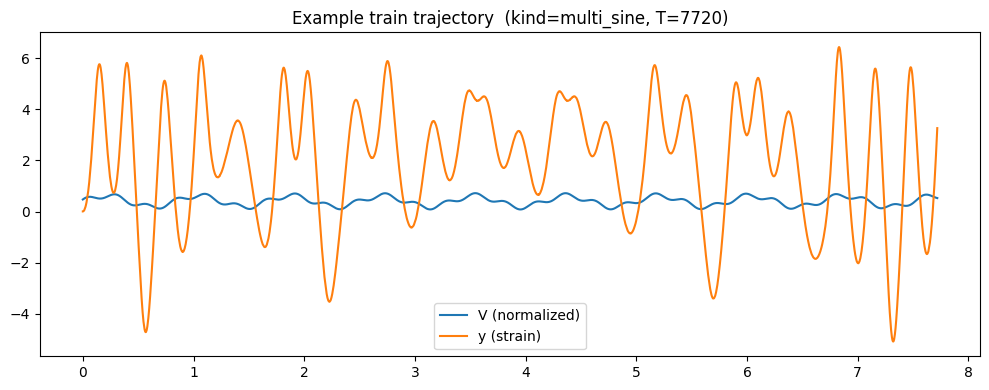

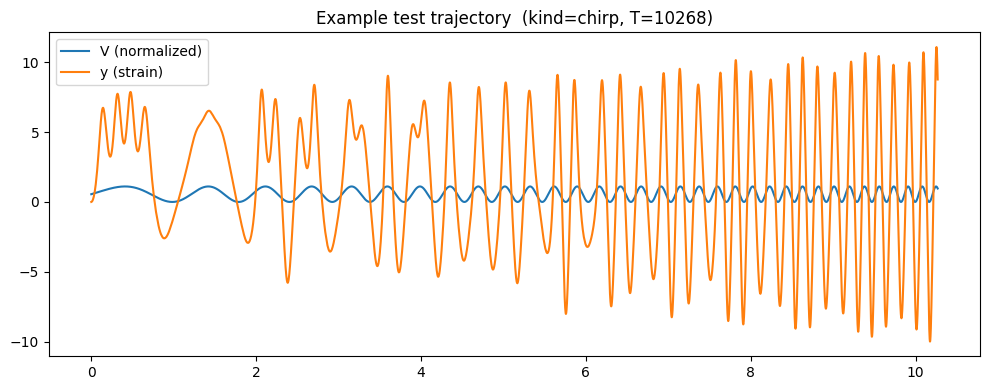

In [ ]:
def plot_trajectory(traj, title=""):
    Vn = traj.V / 2500.0
    t = np.arange(len(traj.V)) * traj.dt
    plt.figure(figsize=(10,4))
    plt.plot(t, Vn, label="V (normalized)")
    plt.plot(t, traj.y, label="y (strain)")
    plt.legend()
    plt.title(title + f"  (kind={traj.kind}, T={len(traj.V)})")
    plt.tight_layout()
    plt.show()

plot_trajectory(train_trajs[0], "Example train trajectory")
plot_trajectory(test_trajs[0], "Example test trajectory")


In [ ]:
# Standardization helpers (fit on training set only)

def fit_standardizer(trajs):
    V_all = np.concatenate([tr.V for tr in trajs]).astype(np.float64)
    y_all = np.concatenate([tr.y for tr in trajs]).astype(np.float64)
    stats = {
        "V_mean": V_all.mean(),
        "V_std": V_all.std() + 1e-9,
        "y_mean": y_all.mean(),
        "y_std": y_all.std() + 1e-9,
    }
    return stats

def standardize_V(V, stats):
    return (V - stats["V_mean"]) / stats["V_std"]

def standardize_y(y, stats):
    return (y - stats["y_mean"]) / stats["y_std"]

def destandardize_y(yz, stats):
    return yz * stats["y_std"] + stats["y_mean"]

stats = fit_standardizer(train_trajs)
stats


{'V_mean': np.float64(651.2860555084507),
 'V_std': np.float64(711.5558956749406),
 'y_mean': np.float64(0.8104719139313472),
 'y_std': np.float64(3.697234115173326)}

## 3) Baseline model: simple first-order linear dynamics

A minimal physics-inspired baseline is a discrete first-order system:
\[
\hat{y}_t = a\hat{y}_{t-1} + bV_t + c
\]
This is intentionally simple. It will struggle with:
- Nonlinearity (true drive depends on \(V^2\))
- Hysteresis and memory (internal state)
- Oscillatory behavior beyond first-order dynamics

We fit \(a,b,c\) by least squares on the training set.


In [ ]:
def fit_first_order_baseline(train_trajs, stats):
    # Build regression: y_t = a*y_{t-1} + b*V_t + c
    X_list = []
    Y_list = []
    for tr in train_trajs:
        Vz = standardize_V(tr.V, stats)
        yz = standardize_y(tr.y, stats)
        y_prev = yz[:-1]
        V_now = Vz[1:]
        ones = np.ones_like(V_now)
        X = np.stack([y_prev, V_now, ones], axis=1)
        Y = yz[1:]
        X_list.append(X)
        Y_list.append(Y)
    X_all = np.concatenate(X_list, axis=0)
    Y_all = np.concatenate(Y_list, axis=0)

    # Least squares
    theta, *_ = np.linalg.lstsq(X_all, Y_all, rcond=None)
    a, b, c = theta
    return float(a), float(b), float(c)

def predict_first_order(traj, stats, a, b, c):
    Vz = standardize_V(traj.V, stats)
    # initialize at true y0 (typical in system ID evaluations)
    yz_hat = np.zeros_like(Vz, dtype=np.float64)
    yz_true = standardize_y(traj.y, stats)
    yz_hat[0] = yz_true[0]
    for t in range(1, len(Vz)):
        yz_hat[t] = a * yz_hat[t-1] + b * Vz[t] + c
    y_hat = destandardize_y(yz_hat, stats)
    return y_hat

a0, b0, c0 = fit_first_order_baseline(train_trajs, stats)
a0, b0, c0


(0.9978036529678375, 0.004188610099878402, -2.001455407218593e-05)

In [ ]:
def mse(y_true, y_pred):
    return float(np.mean((y_true - y_pred)**2))

def nrmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    denom = np.std(y_true) + 1e-9
    return float(rmse / denom)

def eval_model_on_set(trajs, pred_fn, name="model"):
    mses = []
    nrmses = []
    for tr in trajs:
        yhat = pred_fn(tr)
        mses.append(mse(tr.y, yhat))
        nrmses.append(nrmse(tr.y, yhat))
    return {
        "name": name,
        "MSE_mean": float(np.mean(mses)),
        "MSE_std": float(np.std(mses)),
        "NRMSE_mean": float(np.mean(nrmses)),
        "NRMSE_std": float(np.std(nrmses)),
    }

baseline_pred = lambda tr: predict_first_order(tr, stats, a0, b0, c0)

baseline_train = eval_model_on_set(train_trajs, baseline_pred, "Baseline 1st-order")
baseline_val = eval_model_on_set(val_trajs, baseline_pred, "Baseline 1st-order")
baseline_test = eval_model_on_set(test_trajs, baseline_pred, "Baseline 1st-order")

baseline_train, baseline_val, baseline_test


({'name': 'Baseline 1st-order',
  'MSE_mean': 29.734683049954615,
  'MSE_std': 9.743148236613736,
  'NRMSE_mean': 1.548674192603355,
  'NRMSE_std': 0.2970357088889664},
 {'name': 'Baseline 1st-order',
  'MSE_mean': 26.287673917286508,
  'MSE_std': 9.957261558396413,
  'NRMSE_mean': 1.9530403847338438,
  'NRMSE_std': 0.38099558305209225},
 {'name': 'Baseline 1st-order',
  'MSE_mean': 42.529109542807994,
  'MSE_std': 20.92657115066401,
  'NRMSE_mean': 1.3455839171747241,
  'NRMSE_std': 0.2907159055365674})

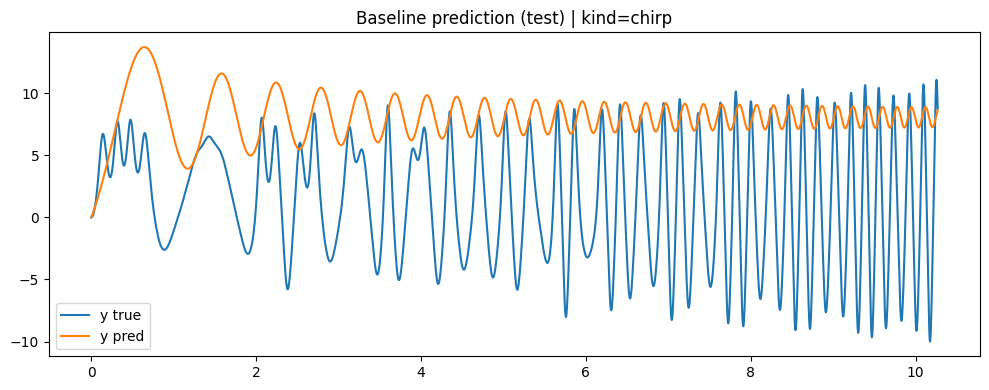

In [ ]:
def plot_prediction(traj, yhat, title=""):
    t = np.arange(len(traj.y)) * traj.dt
    plt.figure(figsize=(10,4))
    plt.plot(t, traj.y, label="y true")
    plt.plot(t, yhat, label="y pred")
    plt.title(title + f" | kind={traj.kind}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot on a test trajectory
tr = test_trajs[0]
yhat = baseline_pred(tr)
plot_prediction(tr, yhat, "Baseline prediction (test)")


## 4) Learned model 1: Windowed MLP

We predict \(y_t\) from a rolling window:
- Voltage window \([V_{t-w},\ldots,V_t]\)
- Output history \([y_{t-w},\ldots,y_{t-1}]\)

This is a standard nonlinear system identification approach (NARX-like).
It can learn nonlinearities, but has limited long-term memory beyond the window.


In [ ]:
class WindowDataset(Dataset):
    def __init__(self, trajs, stats, w=50):
        self.X = []
        self.Y = []
        self.w = w
        for tr in trajs:
            Vz = standardize_V(tr.V, stats)
            yz = standardize_y(tr.y, stats)
            for t in range(w, len(Vz)):
                V_win = Vz[t-w:t+1]          # w+1
                y_hist = yz[t-w:t]           # w
                x = np.concatenate([V_win, y_hist], axis=0)  # (w+1+w)
                self.X.append(x.astype(np.float32))
                self.Y.append(np.array([yz[t]], dtype=np.float32))
        self.X = np.stack(self.X, axis=0)
        self.Y = np.stack(self.Y, axis=0)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

w = 60
train_ds = WindowDataset(train_trajs, stats, w=w)
val_ds   = WindowDataset(val_trajs, stats, w=w)

train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=2048, shuffle=False)

train_ds.X.shape, train_ds.Y.shape


((88897, 121), (88897, 1))

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )
    def forward(self, x):
        return self.net(x)

mlp = MLP(in_dim=train_ds.X.shape[1], hidden=256).to(device)
opt = torch.optim.Adam(mlp.parameters(), lr=2e-3)
loss_fn = nn.MSELoss()

def run_epoch(model, loader, train=True):
    model.train(train)
    total = 0.0
    n = 0
    with torch.set_grad_enabled(train):
        for Xb, Yb in loader:
            Xb = Xb.to(device)
            Yb = Yb.to(device)
            pred = model(Xb)
            loss = loss_fn(pred, Yb)
            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()
            total += float(loss.item()) * Xb.size(0)
            n += Xb.size(0)
    return total / max(n,1)

best_val = float("inf")
best_state = None

for epoch in range(1, 31):
    tr_loss = run_epoch(mlp, train_loader, train=True)
    va_loss = run_epoch(mlp, val_loader, train=False)
    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in mlp.state_dict().items()}
    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:02d} | train MSE(z)={tr_loss:.6f} | val MSE(z)={va_loss:.6f}")

mlp.load_state_dict(best_state)
print("Best val MSE(z):", best_val)


epoch 01 | train MSE(z)=0.061430 | val MSE(z)=0.001258
epoch 05 | train MSE(z)=0.000233 | val MSE(z)=0.000138
epoch 10 | train MSE(z)=0.000365 | val MSE(z)=0.000042
epoch 15 | train MSE(z)=0.000069 | val MSE(z)=0.000050
epoch 20 | train MSE(z)=0.000063 | val MSE(z)=0.000035
epoch 25 | train MSE(z)=0.000215 | val MSE(z)=0.000061
epoch 30 | train MSE(z)=0.000028 | val MSE(z)=0.000024
Best val MSE(z): 1.5544933870234685e-05


In [ ]:
@torch.no_grad()
def predict_mlp_rollout(traj, stats, model, w=60):
    model.eval()
    Vz = standardize_V(traj.V, stats).astype(np.float32)
    yz_true = standardize_y(traj.y, stats).astype(np.float32)

    yz_hat = np.zeros_like(Vz, dtype=np.float32)
    yz_hat[:w] = yz_true[:w]  # warm start using true history for the first window

    for t in range(w, len(Vz)):
        V_win = Vz[t-w:t+1]         # w+1
        y_hist = yz_hat[t-w:t]      # w (autoregressive rollout)
        x = np.concatenate([V_win, y_hist], axis=0)[None, :]
        xt = torch.from_numpy(x).to(device)
        yz_hat[t] = model(xt).cpu().numpy().reshape(-1)[0]

    return destandardize_y(yz_hat, stats)

mlp_pred = lambda tr: predict_mlp_rollout(tr, stats, mlp, w=w)

mlp_train = eval_model_on_set(train_trajs, mlp_pred, "MLP windowed")
mlp_val   = eval_model_on_set(val_trajs, mlp_pred, "MLP windowed")
mlp_test  = eval_model_on_set(test_trajs, mlp_pred, "MLP windowed")

mlp_train, mlp_val, mlp_test


({'name': 'MLP windowed',
  'MSE_mean': 14.818360271824469,
  'MSE_std': 5.874632529127113,
  'NRMSE_mean': 1.112138338340553,
  'NRMSE_std': 0.22795444821720195},
 {'name': 'MLP windowed',
  'MSE_mean': 10.38041867843402,
  'MSE_std': 5.4469332112137385,
  'NRMSE_mean': 1.235645719765308,
  'NRMSE_std': 0.44496363216378615},
 {'name': 'MLP windowed',
  'MSE_mean': 20.28803438932419,
  'MSE_std': 2.7063448439981546,
  'NRMSE_mean': 0.969063441654314,
  'NRMSE_std': 0.06496825717411621})

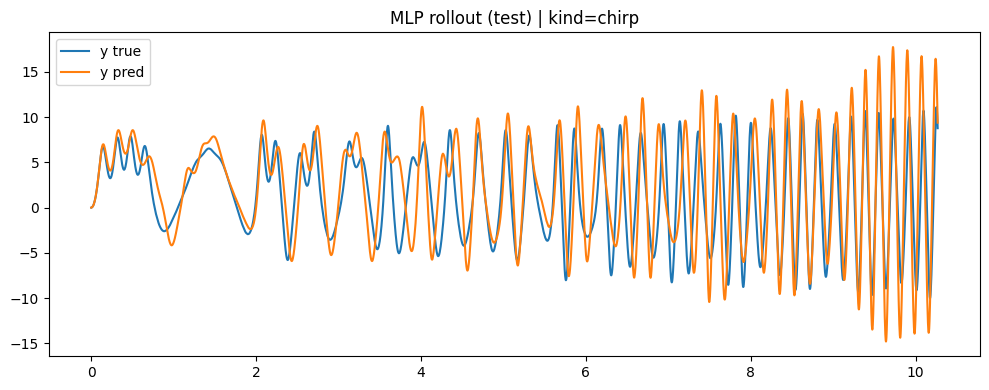

In [ ]:
tr = test_trajs[0]
yhat = mlp_pred(tr)
plot_prediction(tr, yhat, "MLP rollout (test)")


## 5) Learned model 2: LSTM sequence model

We train a sequence-to-sequence predictor:
- Input sequence: standardized voltage \(V_{1:T}\)
- Output sequence: standardized strain \(y_{1:T}\)

We train with teacher forcing (predict next output given past outputs during training),
then evaluate with autoregressive rollout at test time.


In [ ]:
class SeqDataset(Dataset):
    def __init__(self, trajs, stats, max_len=12000):
        self.trajs = trajs
        self.stats = stats
        self.max_len = max_len

    def __len__(self):
        return len(self.trajs)

    def __getitem__(self, idx):
        tr = self.trajs[idx]
        Vz = standardize_V(tr.V, self.stats).astype(np.float32)
        yz = standardize_y(tr.y, self.stats).astype(np.float32)
        # Optional truncation for batching
        L = min(len(Vz), self.max_len)
        return Vz[:L], yz[:L], L

def collate_batch(batch):
    # Pad to max length in batch
    lengths = [b[2] for b in batch]
    Lmax = max(lengths)
    Vp = np.zeros((len(batch), Lmax, 1), dtype=np.float32)
    Yp = np.zeros((len(batch), Lmax, 1), dtype=np.float32)
    mask = np.zeros((len(batch), Lmax), dtype=np.float32)
    for i, (V, Y, L) in enumerate(batch):
        Vp[i, :L, 0] = V
        Yp[i, :L, 0] = Y
        mask[i, :L] = 1.0
    return torch.from_numpy(Vp), torch.from_numpy(Yp), torch.from_numpy(mask), torch.tensor(lengths)

seq_train = SeqDataset(train_trajs, stats)
seq_val   = SeqDataset(val_trajs, stats)

seq_train_loader = DataLoader(seq_train, batch_size=4, shuffle=True, collate_fn=collate_batch)
seq_val_loader   = DataLoader(seq_val, batch_size=4, shuffle=False, collate_fn=collate_batch)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, hidden=64, layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=hidden, num_layers=layers, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )

    def forward(self, V_seq, y_prev_seq):
        # Concatenate inputs along feature dim: [V_t, y_{t-1}]
        x = torch.cat([V_seq, y_prev_seq], dim=-1)
        h, _ = self.lstm(x)
        out = self.head(h)
        return out

lstm = LSTMModel(hidden=96, layers=2).to(device)
opt2 = torch.optim.Adam(lstm.parameters(), lr=2e-3)
loss_fn = nn.MSELoss(reduction="none")

def run_seq_epoch(model, loader, train=True):
    model.train(train)
    total = 0.0
    count = 0.0
    with torch.set_grad_enabled(train):
        for Vp, Yp, mask, lengths in loader:
            Vp = Vp.to(device)
            Yp = Yp.to(device)
            mask = mask.to(device)

            # Teacher forcing setup:
            # y_prev(t) = y(t-1), with y_prev(0) = y(0)
            y_prev = torch.zeros_like(Yp)
            y_prev[:, 0, :] = Yp[:, 0, :]
            y_prev[:, 1:, :] = Yp[:, :-1, :]

            pred = model(Vp, y_prev)

            # masked MSE
            mse_t = loss_fn(pred, Yp).squeeze(-1) * mask
            loss = mse_t.sum() / (mask.sum() + 1e-9)

            if train:
                opt2.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt2.step()

            total += float(loss.item()) * float(mask.sum().item())
            count += float(mask.sum().item())
    return total / max(count, 1.0)

best_val = float("inf")
best_state = None

for epoch in range(1, 41):
    tr_loss = run_seq_epoch(lstm, seq_train_loader, train=True)
    va_loss = run_seq_epoch(lstm, seq_val_loader, train=False)
    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in lstm.state_dict().items()}
    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:02d} | train MSE(z)={tr_loss:.6f} | val MSE(z)={va_loss:.6f}")

lstm.load_state_dict(best_state)
print("Best val MSE(z):", best_val)


epoch 01 | train MSE(z)=0.966775 | val MSE(z)=0.450036
epoch 05 | train MSE(z)=0.253323 | val MSE(z)=0.017764
epoch 10 | train MSE(z)=0.030989 | val MSE(z)=0.011167
epoch 15 | train MSE(z)=0.012464 | val MSE(z)=0.002493
epoch 20 | train MSE(z)=0.007399 | val MSE(z)=0.002388
epoch 25 | train MSE(z)=0.003116 | val MSE(z)=0.000780
epoch 30 | train MSE(z)=0.001551 | val MSE(z)=0.000405
epoch 35 | train MSE(z)=0.000658 | val MSE(z)=0.000195
epoch 40 | train MSE(z)=0.000265 | val MSE(z)=0.000119
Best val MSE(z): 0.00011947090388275683


In [ ]:
@torch.no_grad()
def predict_lstm_rollout(traj, stats, model):
    model.eval()
    Vz = standardize_V(traj.V, stats).astype(np.float32)
    yz_true = standardize_y(traj.y, stats).astype(np.float32)

    # Autoregressive rollout
    yz_hat = np.zeros_like(Vz, dtype=np.float32)
    yz_hat[0] = yz_true[0]

    h = None  # we will just call model step-wise using a 1-step sequence for simplicity
    # For simplicity and clarity, we do stepwise inference by feeding a length-1 sequence.
    for t in range(1, len(Vz)):
        Vt = torch.tensor([[[Vz[t]]]], dtype=torch.float32, device=device)      # [1,1,1]
        yprev = torch.tensor([[[yz_hat[t-1]]]], dtype=torch.float32, device=device)  # [1,1,1]

        # Build [1,1,2] input inside forward
        pred = model(Vt, yprev)  # returns [1,1,1]
        yz_hat[t] = pred.squeeze().item()

    return destandardize_y(yz_hat, stats)

lstm_pred = lambda tr: predict_lstm_rollout(tr, stats, lstm)

lstm_train = eval_model_on_set(train_trajs, lstm_pred, "LSTM")
lstm_val   = eval_model_on_set(val_trajs, lstm_pred, "LSTM")
lstm_test  = eval_model_on_set(test_trajs, lstm_pred, "LSTM")

lstm_train, lstm_val, lstm_test


({'name': 'LSTM',
  'MSE_mean': 13.172993181474306,
  'MSE_std': 5.3695312926731305,
  'NRMSE_mean': 1.013392365981358,
  'NRMSE_std': 0.0325386110722751},
 {'name': 'LSTM',
  'MSE_mean': 7.150610231992934,
  'MSE_std': 1.2678063175433778,
  'NRMSE_mean': 1.0487741828694153,
  'NRMSE_std': 0.00782855162034575},
 {'name': 'LSTM',
  'MSE_mean': 20.36142181108004,
  'MSE_std': 1.5284633760110755,
  'NRMSE_mean': 0.9719447032771732,
  'NRMSE_std': 0.010219594759295372})

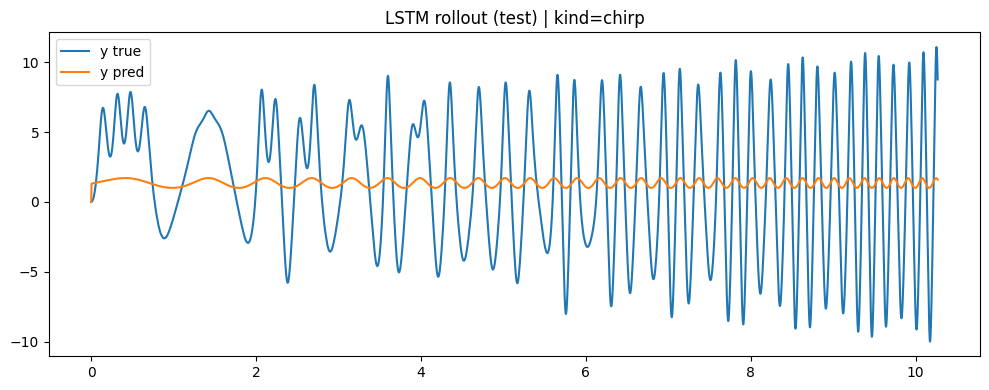

In [ ]:
tr = test_trajs[0]
yhat = lstm_pred(tr)
plot_prediction(tr, yhat, "LSTM rollout (test)")


## 6) Results summary and discussion

We compare:
- Baseline first-order model
- Windowed MLP
- LSTM

We report MSE and NRMSE on train/val/test.


In [ ]:
import pandas as pd

rows = []
for dset_name, res_base, res_mlp, res_lstm in [
    ("train", baseline_train, mlp_train, lstm_train),
    ("val", baseline_val, mlp_val, lstm_val),
    ("test", baseline_test, mlp_test, lstm_test),
]:
    for res in [res_base, res_mlp, res_lstm]:
        rows.append({
            "split": dset_name,
            "model": res["name"],
            "MSE_mean": res["MSE_mean"],
            "NRMSE_mean": res["NRMSE_mean"],
        })

df = pd.DataFrame(rows)
df


,split,model,MSE_mean,NRMSE_mean
0,train,Baseline 1st-order,29.734683,1.548674
1,train,MLP windowed,14.818360,1.112138
2,train,LSTM,13.172993,1.013392
3,val,Baseline 1st-order,26.287674,1.953040
4,val,MLP windowed,10.380419,1.235646
5,val,LSTM,7.150610,1.048774
6,test,Baseline 1st-order,42.529110,1.345584
7,test,MLP windowed,20.288034,0.969063
8,test,LSTM,20.361422,0.971945
